In [1]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import pprint
import pyspark
import pyspark.sql.functions as F
import seaborn as sns
import math

from pyspark.sql.functions import col, round, expr, count, mean, min, max, stddev, skewness, kurtosis, percentile_approx, lit, split, explode, trim, regexp_replace, transform, array_contains, when, regexp_extract, coalesce
from pyspark.sql.types import StringType, IntegerType, FloatType, DateType

from pyspark.sql.functions import col, regexp_replace

import utils.data_processing_bronze_table
import utils.data_processing_silver_table
import utils.data_processing_gold_table
import utils.data_processing_features
import utils.generator_fn as fn

## set up pyspark session

In [2]:
# Initialize SparkSession, sets up pyspark cluster on computer.
spark = pyspark.sql.SparkSession.builder \
    .appName("dev") \
    .master("local[*]") \
    .getOrCreate()

# Set log level to ERROR to hide warnings
spark.sparkContext.setLogLevel("ERROR")

## set up config

In [3]:
# set up config
snapshot_date_str = "2025-11-01"

start_date_str = "2023-01-01"
end_date_str = "2025-01-01"

In [4]:
dates_str_lst = fn.generate_first_of_month_dates(start_date_str, end_date_str)
dates_str_lst

['2023-01-01',
 '2023-02-01',
 '2023-03-01',
 '2023-04-01',
 '2023-05-01',
 '2023-06-01',
 '2023-07-01',
 '2023-08-01',
 '2023-09-01',
 '2023-10-01',
 '2023-11-01',
 '2023-12-01',
 '2024-01-01',
 '2024-02-01',
 '2024-03-01',
 '2024-04-01',
 '2024-05-01',
 '2024-06-01',
 '2024-07-01',
 '2024-08-01',
 '2024-09-01',
 '2024-10-01',
 '2024-11-01',
 '2024-12-01',
 '2025-01-01']

## Build Bronze Table

In [5]:
bronze_feature_directory = "datamart/bronze/"

In [6]:
for date_str in dates_str_lst:

    # Process all data types for this date
    utils.data_processing_bronze_table.process_bronze_feature_tables(date_str, bronze_feature_directory, spark)

Processing financials data...
financials data row count: 12500
Saved financials data to: datamart/bronze/bronze_financials.csv
Processing attributes data...
attributes data row count: 12500
Saved attributes data to: datamart/bronze/bronze_attributes.csv
Processing clickstream data for 2023-01-01...
clickstream data for 2023-01-01 row count: 8974
Saved clickstream data to: datamart/bronze//clickstream/bronze_clickstream_2023_01_01.csv
All bronze feature tables for 2023-01-01 processed successfully.
Processing financials data...
financials data row count: 12500
Saved financials data to: datamart/bronze/bronze_financials.csv
Processing attributes data...
attributes data row count: 12500
Saved attributes data to: datamart/bronze/bronze_attributes.csv
Processing clickstream data for 2023-02-01...
clickstream data for 2023-02-01 row count: 8974
Saved clickstream data to: datamart/bronze//clickstream/bronze_clickstream_2023_02_01.csv
All bronze feature tables for 2023-02-01 processed successf

## Build Silver Table - Features

In [5]:
silver_feature_directory = "datamart/silver/"

if not os.path.exists(silver_feature_directory):
    os.makedirs(silver_feature_directory)

In [7]:
utils.data_processing_features.process_customer_features(bronze_feature_directory, silver_feature_directory, spark)
for date_str in dates_str_lst:
    utils.data_processing_features.process_silver_cs_features(date_str, bronze_feature_directory, silver_feature_directory, spark)

------------Processing for financials and attributes------------
loaded from: datamart/bronze/bronze_financials.csv row count: 12500
Processing financials data complete. Financials data row count: 12495
Begin to process attributes data
loaded from: DataFrame[Customer_ID: string, Name: string, Age: string, SSN: string, Occupation: string, snapshot_date: date] row count: 12500
Processing attributes data complete
Attributes data row count: 12500
Merging financials and attributes data complete
Merge complete. features_df row count: 12495
saved to: datamart/silver/silver_financial_attributes.parquet
processing clickstream data starting....
clickstream processing complete. clickstream row_count: 8974
saved to: datamart/silver/clickstream/silver_clickstream_daily_2023_01_01.parquet
processing clickstream data starting....
clickstream processing complete. clickstream row_count: 8974
saved to: datamart/silver/clickstream/silver_clickstream_daily_2023_02_01.parquet
processing clickstream data st

In [6]:
gold_feature_directory = "datamart/gold/feature_store/"

if not os.path.exists(gold_feature_directory):
    os.makedirs(gold_feature_directory)

In [7]:
for date_str in dates_str_lst:
    utils.data_processing_gold_table.process_features_gold_table(date_str, end_date_str,silver_feature_directory, gold_feature_directory, spark)

loaded from: datamart/silver/silver_financial_attributes.parquet row count: 12495
+-----------+-----+-----+-----+-----+------+-----+-----+------+------+-----+------+-----+------+------+------+------+------+------+-----+-----+-------------+-------------+-----------------+---------------+-------------+-----------+-------------------+----------------------+--------------------+--------------------+----------------+------------------------+-------------------+-----------------------+---------------+-------------------------+--------------------------+---------------------+-----------------------+---------------------------------+-----------------------+----------------------+-----------------------------+-------------------+-----------------------+---------------+--------------+------------------+-------------------+------------------------+-------------------------+--------------+------------+
|Customer_ID| fe_1| fe_2| fe_3| fe_4|  fe_5| fe_6| fe_7|  fe_8|  fe_9|fe_10| fe_11|fe_12| fe_13|

## EDA and data preprocessing for features financials dataset

In [4]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 20)

In [16]:
financials_df = spark.read.csv("data/features_financials.csv", header=True, inferSchema=True)
financials_df.toPandas()

,Customer_ID,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,snapshot_date
0,CUS_0x1000,30625.94,2706.161667,6,5,27,2,"Credit-Builder Loan, and Home Equity Loan",57,26,...,Bad,1562.91,30.077191,10 Years and 9 Months,Yes,42.941090,77.31427572208112,High_spent_Medium_value_payments,400.36080052211616,2023-05-01
1,CUS_0x1009,52312.68_,4250.390000,6,5,17,4,"Not Specified, Home Equity Loan, Credit-Builde...",5,18,...,_,202.68,40.286997,31 Years and 0 Months,Yes,108.366467,58.66019164829086,High_spent_Medium_value_payments,508.01234122645366,2025-01-01
2,CUS_0x100b,113781.38999999998,9549.782500,1,4,1,0,None,14,8,...,Good,1030.2,28.592943,15 Years and 10 Months,No,0.000000,617.0792665202719,High_spent_Small_value_payments,597.8989834797281,2024-03-01
3,CUS_0x1011,58918.47,5208.872500,3,3,17,3,"Student Loan, Credit-Builder Loan, and Debt Co...",27,13,...,Standard,473.14,27.829959,15 Years and 10 Months,Yes,123.434939,383.35084463651407,Low_spent_Medium_value_payments,294.1014665671429,2023-11-01
4,CUS_0x1013,98620.98,7962.415000,3,3,6,3,"Student Loan, Debt Consolidation Loan, and Per...",12,9,...,Good,1233.51,26.524864,17 Years and 10 Months,No,228.018084,332.3337079767732,High_spent_Medium_value_payments,485.8897083704929,2023-12-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12495,CUS_0xff3,17032.785,1176.398750,0,6,2,3,"Personal Loan, Mortgage Loan, and Auto Loan",13,7_,...,Good,1229.08,26.915577,17 Years and 3 Months,No,33.299764,81.19585741743609,Low_spent_Small_value_payments,293.14425404017936,2024-06-01
12496,CUS_0xff4,25546.26,2415.855000,8,7,14,5_,"Not Specified, Student Loan, Student Loan, Cre...",15,13_,...,Standard,758.44,39.333488,18 Years and 9 Months,Yes,101.328637,189.81586133347676,Low_spent_Medium_value_payments,230.44100130267208,2024-12-01
12497,CUS_0xff6,117639.92,9727.326667,5,6,1,2,"Home Equity Loan, and Auto Loan",-3,7,...,Good,338.3,32.871853,24 Years and 11 Months,No,126.638453,534.0885271982645,Low_spent_Medium_value_payments,592.0056861539196,2024-10-01
12498,CUS_0xffc,60877.17,5218.097500,6,8,27,8,"Credit-Builder Loan, Payday Loan, Not Specifie...",46,14,...,_,1300.13,29.026498,13 Years and 1 Months,Yes,272.809169,46.4256138380274,High_spent_Large_value_payments,442.5749666782518,2024-01-01


In [13]:
latest_date = financials_df.agg(F.max("snapshot_date")).collect()[0][0]
print(f"Latest date in DataFrame: {latest_date}")


Latest date in DataFrame: 2025-01-01


In [13]:
financials_df.dtypes

[('Customer_ID', 'string'),
 ('Annual_Income', 'string'),
 ('Monthly_Inhand_Salary', 'double'),
 ('Num_Bank_Accounts', 'int'),
 ('Num_Credit_Card', 'int'),
 ('Interest_Rate', 'int'),
 ('Num_of_Loan', 'string'),
 ('Type_of_Loan', 'string'),
 ('Delay_from_due_date', 'int'),
 ('Num_of_Delayed_Payment', 'string'),
 ('Changed_Credit_Limit', 'string'),
 ('Num_Credit_Inquiries', 'double'),
 ('Credit_Mix', 'string'),
 ('Outstanding_Debt', 'string'),
 ('Credit_Utilization_Ratio', 'double'),
 ('Credit_History_Age', 'string'),
 ('Payment_of_Min_Amount', 'string'),
 ('Total_EMI_per_month', 'double'),
 ('Amount_invested_monthly', 'string'),
 ('Payment_Behaviour', 'string'),
 ('Monthly_Balance', 'string'),
 ('snapshot_date', 'date')]

In [10]:
# Format numerical columns to remove non-numeric characters
df1 = financials_df.withColumn("Annual_Income", regexp_replace(F.col("Annual_Income"), "[^0-9\\.]", "")) \
    .withColumn("Num_of_Loan", regexp_replace(F.col("Num_of_Loan"), "[^0-9s\\.]", "")) \
    .withColumn("Num_of_Delayed_Payment", regexp_replace(F.col("Num_of_Delayed_Payment"), "[^0-9\\.]", "")) \
    .withColumn("Changed_Credit_Limit", regexp_replace(F.col("Changed_Credit_Limit"), "[^0-9\\.]", "")) \
    .withColumn("Outstanding_Debt", regexp_replace(F.col("Outstanding_Debt"), "[^0-9\\.]", "")) \
    .withColumn("Amount_invested_monthly", regexp_replace(F.col("Amount_invested_monthly"), "[^0-9\\.]", "")) \
    .withColumn("Monthly_Balance", regexp_replace(F.col("Monthly_Balance"), "[^0-9\\.]", ""))

# Format data types
df2 = df1.withColumn("Annual_Income", F.col("Annual_Income").cast("double")) \
    .withColumn("Num_of_Loan", F.col("Num_of_Loan").cast("int")) \
    .withColumn("Num_of_Delayed_Payment", F.col("Num_of_Delayed_Payment").cast("int")) \
    .withColumn("Num_Credit_Inquiries", F.col("Num_Credit_Inquiries").cast("int")) \
    .withColumn("Changed_Credit_Limit", F.col("Changed_Credit_Limit").cast("double")) \
    .withColumn("Amount_invested_monthly", F.col("Amount_invested_monthly").cast("double"))

df3 = df2.withColumn("Annual_Income", F.round(F.col("Annual_Income"), 2)) \
    .withColumn("Monthly_Inhand_Salary", F.round(F.col("Monthly_Inhand_Salary"), 2)) \
    .withColumn("Num_of_Loan", F.round(F.col("Num_of_Loan"), 2)) \
    .withColumn("Num_of_Delayed_Payment", F.round(F.col("Num_of_Delayed_Payment"), 2)) \
    .withColumn("Changed_Credit_Limit", F.round(F.col("Changed_Credit_Limit"), 2)) \
    .withColumn("Outstanding_Debt", F.round(F.col("Outstanding_Debt"), 2)) \
    .withColumn("Credit_Utilization_Ratio", F.round(F.col("Credit_Utilization_Ratio"), 2)) \
    .withColumn("Total_EMI_per_month", F.round(F.col("Total_EMI_per_month"), 2)) \
    .withColumn("Amount_invested_monthly", F.round(F.col("Amount_invested_monthly"), 2)) \
    .withColumn("Monthly_Balance", F.round(F.col("Monthly_Balance"), 2))

df4 = df3.withColumn("Credit_History_Age_Months", 
                     (coalesce(regexp_extract(F.col("Credit_History_Age"), "([0-9]+) Years?", 1).cast("float"), F.lit(0)) * 12) + 
                     coalesce(regexp_extract(F.col("Credit_History_Age"), "([0-9]+) Months?", 1).cast("float"), F.lit(0))
                    )

df5 = df4.drop("Credit_History_Age")

df5.toPandas()

,Customer_ID,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,snapshot_date,Credit_History_Age_Months
0,CUS_0x1000,30625.94,2706.16,6,5,27,2,"Credit-Builder Loan, and Home Equity Loan",57,26,...,Bad,1562.91,30.08,Yes,42.94,77.31,High_spent_Medium_value_payments,400.36,2023-05-01,129.0
1,CUS_0x1009,52312.68,4250.39,6,5,17,4,"Not Specified, Home Equity Loan, Credit-Builde...",5,18,...,_,202.68,40.29,Yes,108.37,58.66,High_spent_Medium_value_payments,508.01,2025-01-01,372.0
2,CUS_0x100b,113781.39,9549.78,1,4,1,0,None,14,8,...,Good,1030.20,28.59,No,0.00,617.08,High_spent_Small_value_payments,597.90,2024-03-01,190.0
3,CUS_0x1011,58918.47,5208.87,3,3,17,3,"Student Loan, Credit-Builder Loan, and Debt Co...",27,13,...,Standard,473.14,27.83,Yes,123.43,383.35,Low_spent_Medium_value_payments,294.10,2023-11-01,190.0
4,CUS_0x1013,98620.98,7962.42,3,3,6,3,"Student Loan, Debt Consolidation Loan, and Per...",12,9,...,Good,1233.51,26.52,No,228.02,332.33,High_spent_Medium_value_payments,485.89,2023-12-01,214.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12495,CUS_0xff3,17032.79,1176.40,0,6,2,3,"Personal Loan, Mortgage Loan, and Auto Loan",13,7,...,Good,1229.08,26.92,No,33.30,81.20,Low_spent_Small_value_payments,293.14,2024-06-01,207.0
12496,CUS_0xff4,25546.26,2415.86,8,7,14,5,"Not Specified, Student Loan, Student Loan, Cre...",15,13,...,Standard,758.44,39.33,Yes,101.33,189.82,Low_spent_Medium_value_payments,230.44,2024-12-01,225.0
12497,CUS_0xff6,117639.92,9727.33,5,6,1,2,"Home Equity Loan, and Auto Loan",-3,7,...,Good,338.30,32.87,No,126.64,534.09,Low_spent_Medium_value_payments,592.01,2024-10-01,299.0
12498,CUS_0xffc,60877.17,5218.10,6,8,27,8,"Credit-Builder Loan, Payday Loan, Not Specifie...",46,14,...,_,1300.13,29.03,Yes,272.81,46.43,High_spent_Large_value_payments,442.57,2024-01-01,157.0


In [7]:
# Get numeric columns
numeric_cols = [col_name for col_name, dtype in df5.dtypes if dtype in ('int', 'double', 'float')]

# Store results
all_stats = []

# To calculate statistics for numeric columns
for column in numeric_cols:
    stats = df5.select(
        F.lit(column).alias("column"),
        F.count(F.col(column)).alias("count"),
        F.sum(F.when(F.col(column).isNull(), 1).otherwise(0)).alias("null count"),
        F.mean(F.col(column)).alias("mean"),
        F.stddev(F.col(column)).alias("stddev"),
        F.min(F.col(column)).alias("min"),
        F.max(F.col(column)).alias("max"),
        F.skewness(F.col(column)).alias("skewness"),
        F.kurtosis(F.col(column)).alias("kurtosis"),
        F.percentile_approx(F.col(column), 0.5).alias("median")
    ).toPandas()
    all_stats.append(stats)

# Combine all statistics
if all_stats:
    stats_pd = pd.concat(all_stats, ignore_index=True)
    pd.set_option('display.float_format', '{:.2f}'.format)
    display(stats_pd)

,column,count,null count,mean,stddev,min,max,skewness,kurtosis,median
0,Annual_Income,12500,0,161620.55,1297841.64,7005.93,23834698.00,12.76,171.49,37551.78
1,Monthly_Inhand_Salary,12500,0,4188.59,3180.15,303.65,15204.63,1.13,0.62,3085.85
2,Num_Bank_Accounts,12500,0,16.94,114.35,-1.00,1756.00,11.11,131.09,6.00
3,Num_Credit_Card,12500,0,23.17,132.01,0.00,1499.00,8.31,71.84,5.00
4,Interest_Rate,12500,0,73.21,468.68,1.00,5789.00,9.01,85.25,14.00
5,Num_of_Loan,12500,0,11.10,64.23,0.00,1495.00,16.43,308.44,3.00
6,Delay_from_due_date,12500,0,21.06,14.86,-5.00,67.00,0.97,0.35,18.00
7,Num_of_Delayed_Payment,12500,0,33.05,238.69,0.00,4293.00,13.32,187.38,14.00
8,Changed_Credit_Limit,12246,254,10.48,6.67,0.03,36.97,0.72,0.08,9.41
9,Num_Credit_Inquiries,12500,0,26.70,184.19,0.00,2554.00,10.18,108.70,6.00


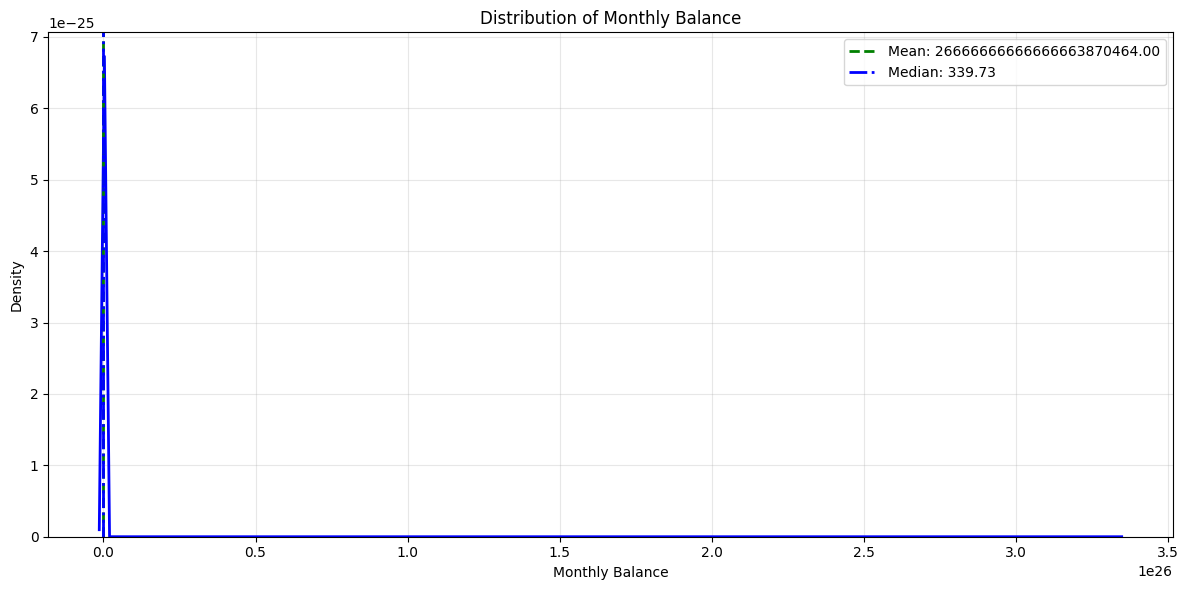

In [27]:
# Plot Monthly_Balance distribution
plt.figure(figsize=(12, 6))

# Convert to pandas
monthly_balance_pd = df5.select("Monthly_Balance").toPandas()

sns.kdeplot(monthly_balance_pd["Monthly_Balance"], color='blue', linewidth=2)

# Add mean and median lines
mean_balance = df5.select(mean("Monthly_Balance")).collect()[0][0]
median_balance = df5.select(percentile_approx("Monthly_Balance", 0.5)).collect()[0][0]

plt.axvline(mean_balance, color='green', linestyle='--', linewidth=2, label=f'Mean: {mean_balance:.2f}')
plt.axvline(median_balance, color='blue', linestyle='-.', linewidth=2, label=f'Median: {median_balance:.2f}')

plt.title('Distribution of Monthly Balance')
plt.xlabel('Monthly Balance')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [11]:
# Remove extreme outlier (3 Stdev) and recheck stats
percentile_997_mb = df5.approxQuantile("Monthly_Balance", [0.997], 0.01)[0]
print(f"99.7th Percentile of Monthly_Balance: {percentile_997_mb}")

df6 = df5.filter(F.col("Monthly_Balance") < percentile_997_mb)
df6_stats= df6.toPandas()
df6_stats.describe()

99.7th Percentile of Monthly_Balance: 3.333333333333333e+26


,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Outstanding_Debt,Credit_Utilization_Ratio,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance,Credit_History_Age_Months
count,1.249900e+04,12499.000000,12499.000000,12499.000000,12499.000000,12499.000000,12499.000000,12499.000000,12245.000000,12499.000000,12499.000000,12499.000000,12499.000000,12499.000000,12499.000000,12499.000000
mean,1.616234e+05,4188.076913,16.940955,23.174014,73.217697,11.100168,21.061765,33.048164,10.481685,26.697176,1426.265696,32.349554,1488.500043,632.333412,403.920914,224.596207
std,1.297894e+06,3179.751950,114.355331,132.011068,468.700726,64.229436,14.863357,238.702405,6.670820,184.201076,1155.204558,5.156902,8561.784251,2034.566100,213.926157,99.649925
min,7.005930e+03,303.650000,-1.000000,0.000000,1.000000,0.000000,-5.000000,0.000000,0.030000,0.000000,0.230000,20.100000,0.000000,0.000000,0.380000,8.000000
25%,1.945324e+04,1624.875000,3.000000,4.000000,8.000000,2.000000,10.000000,9.000000,5.380000,4.000000,566.065000,28.070000,31.500000,73.830000,270.145000,148.000000
50%,3.757083e+04,3086.760000,6.000000,5.000000,14.000000,3.000000,18.000000,14.000000,9.410000,6.000000,1166.230000,32.420000,72.880000,133.980000,339.750000,222.000000
75%,7.268245e+04,5945.780000,7.000000,7.000000,20.000000,6.000000,28.000000,18.000000,14.940000,10.000000,1946.245000,36.620000,169.645000,261.610000,473.380000,305.000000
max,2.383470e+07,15204.630000,1756.000000,1499.000000,5789.000000,1495.000000,67.000000,4293.000000,36.970000,2554.000000,4998.070000,48.200000,81971.000000,10000.000000,1463.790000,404.000000


In [12]:
# Remove number of bank accounts < 0 as it should not be negative
df7 = df6.filter(F.col("Num_Bank_Accounts") >= 0)
df7 = df7.withColumn("Changed_Credit_Limit", F.when(F.col("Changed_Credit_Limit").isNull(), 0).otherwise(F.col("Changed_Credit_Limit")))
df7_stats= df7.toPandas()
df7_stats.describe()

,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Outstanding_Debt,Credit_Utilization_Ratio,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance,Credit_History_Age_Months
count,1.249500e+04,12495.000000,12495.000000,12495.000000,12495.000000,12495.000000,12495.000000,12495.000000,12495.000000,12495.000000,12495.000000,12495.000000,12495.000000,12495.000000,12495.000000,12495.000000
mean,1.598898e+05,4187.445986,16.946699,23.179912,73.239616,11.103241,21.064186,33.057223,10.269517,26.704922,1426.525771,32.349080,1488.956869,632.462314,403.865434,224.580078
std,1.283125e+06,3179.259827,114.373185,132.031785,468.774145,64.239484,14.864460,238.740071,6.767153,184.230046,1155.276974,5.157389,8563.116489,2034.876431,213.910343,99.661461
min,7.005930e+03,303.650000,0.000000,0.000000,1.000000,0.000000,-5.000000,0.000000,0.000000,0.000000,0.230000,20.100000,0.000000,0.000000,0.380000,8.000000
25%,1.944723e+04,1624.265000,3.000000,4.000000,8.000000,2.000000,10.000000,9.000000,5.035000,4.000000,566.065000,28.070000,31.520000,73.830000,270.120000,148.000000
50%,3.757083e+04,3086.760000,6.000000,5.000000,14.000000,3.000000,18.000000,14.000000,9.240000,6.000000,1166.470000,32.420000,72.900000,133.980000,339.680000,222.000000
75%,7.265612e+04,5943.490000,7.000000,7.000000,20.000000,6.000000,28.000000,18.000000,14.730000,10.000000,1947.505000,36.620000,169.645000,261.470000,473.250000,305.000000
max,2.383470e+07,15204.630000,1756.000000,1499.000000,5789.000000,1495.000000,67.000000,4293.000000,36.970000,2554.000000,4998.070000,48.200000,81971.000000,10000.000000,1463.790000,404.000000


In [13]:
# Stats for item counts looks odd. Therefore, we will conduct winsorisation to cap the number of accounts value to those in the 95th percentile. 
percentile_95_acc = df7.approxQuantile("Num_Bank_Accounts", [0.95], 0.01)[0]
percentile_95_cc = df7.approxQuantile("Num_Credit_Card", [0.95], 0.01)[0]  
percentile_95_loan = df7.approxQuantile("Num_of_Loan", [0.95], 0.01)[0]  
percentile_95_dp = df7.approxQuantile("Num_of_Delayed_Payment", [0.95], 0.01)[0]  
percentile_95_ci = df7.approxQuantile("Num_Credit_Inquiries", [0.95], 0.01)[0]  

print(f"95th Percentile of Num_Bank_Accounts: {percentile_95_acc}")
print(f"95th Percentile of Num_Credit_Card: {percentile_95_cc}")
print(f"95th Percentile of Num_of_Loan: {percentile_95_loan}")
print(f"95th Percentile of Num_of_Delayed_Payment: {percentile_95_dp}")
print(f"95th Percentile of Num_Credit_Inquiries: {percentile_95_ci}")

df8 = df7.withColumn("Num_Bank_Accounts", F.when(F.col("Num_Bank_Accounts") > percentile_95_acc, percentile_95_acc).otherwise(F.col("Num_Bank_Accounts"))) \
    .withColumn("Num_Credit_Card", F.when(F.col("Num_Credit_Card") > percentile_95_cc, percentile_95_cc).otherwise(F.col("Num_Credit_Card"))) \
    .withColumn("Num_of_Loan", F.when(F.col("Num_of_Loan") > percentile_95_loan, percentile_95_loan).otherwise(F.col("Num_of_Loan"))) \
    .withColumn("Num_of_Delayed_Payment", F.when(F.col("Num_of_Delayed_Payment") > percentile_95_dp, percentile_95_dp).otherwise(F.col("Num_of_Delayed_Payment"))) \
    .withColumn("Num_Credit_Inquiries", F.when(F.col("Num_Credit_Inquiries") > percentile_95_ci, percentile_95_ci).otherwise(F.col("Num_Credit_Inquiries")))

df8 = df8.withColumn("Num_Bank_Accounts", F.col("Num_Bank_Accounts").cast("int")) \
    .withColumn("Num_Credit_Card", F.col("Num_Credit_Card").cast("int")) \
    .withColumn("Num_of_Loan", F.col("Num_of_Loan").cast("int")) \
    .withColumn("Num_of_Delayed_Payment", F.col("Num_of_Delayed_Payment").cast("int")) \
    .withColumn("Num_Credit_Inquiries", F.col("Num_Credit_Inquiries").cast("int"))

df8_stats= df8.toPandas()
df8_stats.describe()

95th Percentile of Num_Bank_Accounts: 10.0
95th Percentile of Num_Credit_Card: 10.0
95th Percentile of Num_of_Loan: 9.0
95th Percentile of Num_of_Delayed_Payment: 23.0
95th Percentile of Num_Credit_Inquiries: 14.0


,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Outstanding_Debt,Credit_Utilization_Ratio,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance,Credit_History_Age_Months
count,1.249500e+04,12495.000000,12495.000000,12495.000000,12495.000000,12495.000000,12495.000000,12495.000000,12495.000000,12495.000000,12495.000000,12495.000000,12495.000000,12495.000000,12495.000000,12495.000000
mean,1.598898e+05,4187.445986,5.427851,5.640496,73.239616,3.778071,21.064186,13.334774,10.269517,6.695798,1426.525771,32.349080,1488.956869,632.462314,403.865434,224.580078
std,1.283125e+06,3179.259827,2.631414,2.154678,468.774145,2.644716,14.864460,6.153008,6.767153,3.957137,1155.276974,5.157389,8563.116489,2034.876431,213.910343,99.661461
min,7.005930e+03,303.650000,0.000000,0.000000,1.000000,0.000000,-5.000000,0.000000,0.000000,0.000000,0.230000,20.100000,0.000000,0.000000,0.380000,8.000000
25%,1.944723e+04,1624.265000,3.000000,4.000000,8.000000,2.000000,10.000000,9.000000,5.035000,4.000000,566.065000,28.070000,31.520000,73.830000,270.120000,148.000000
50%,3.757083e+04,3086.760000,6.000000,5.000000,14.000000,3.000000,18.000000,14.000000,9.240000,6.000000,1166.470000,32.420000,72.900000,133.980000,339.680000,222.000000
75%,7.265612e+04,5943.490000,7.000000,7.000000,20.000000,6.000000,28.000000,18.000000,14.730000,10.000000,1947.505000,36.620000,169.645000,261.470000,473.250000,305.000000
max,2.383470e+07,15204.630000,10.000000,10.000000,5789.000000,9.000000,67.000000,23.000000,36.970000,14.000000,4998.070000,48.200000,81971.000000,10000.000000,1463.790000,404.000000


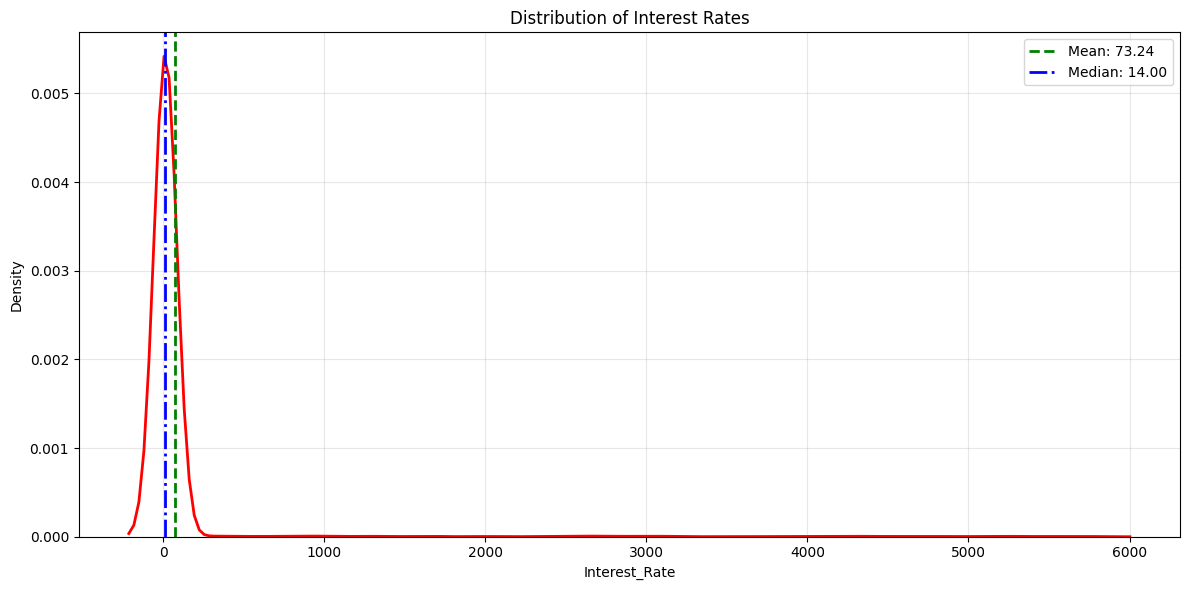

In [11]:
# Plot Interest Rate distribution
plt.figure(figsize=(12, 6))

# Convert to pandas
int_rate = df8.select("Interest_Rate").toPandas()

sns.kdeplot(int_rate["Interest_Rate"], color='r', linewidth=2)

# Add mean and median lines
mean_balance = df8.select(mean("Interest_Rate")).collect()[0][0]
median_balance = df8.select(percentile_approx("Interest_Rate", 0.5)).collect()[0][0]

plt.axvline(mean_balance, color='green', linestyle='--', linewidth=2, label=f'Mean: {mean_balance:.2f}')
plt.axvline(median_balance, color='blue', linestyle='-.', linewidth=2, label=f'Median: {median_balance:.2f}')

plt.title('Distribution of Interest Rates')
plt.xlabel('Interest_Rate')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [12]:
int_rate.describe()

,Interest_Rate
count,12495.00
mean,73.24
std,468.77
min,1.00
25%,8.00
50%,14.00
75%,20.00
max,5789.00


In [14]:
percentile_95_int = df8.approxQuantile("Interest_Rate", [0.95], 0.01)[0]  
print(f"95th Percentile of Interest_Rate: {percentile_95_int}")
df8 = df8.withColumn("Interest_Rate", F.when(F.col("Interest_Rate") > percentile_95_int, percentile_95_int).otherwise(F.col("Interest_Rate")))
df8 = df8.withColumn("Interest_Rate", F.round(F.col("Interest_Rate"), 2))
df8_stats= df8.toPandas()
df8_stats['Interest_Rate'].describe()

95th Percentile of Interest_Rate: 32.0


count    12495.000000
mean        14.890836
std          8.932036
min          1.000000
25%          8.000000
50%         14.000000
75%         20.000000
max         32.000000
Name: Interest_Rate, dtype: float64

In [14]:
distinct_values = df8.select("Payment_of_Min_Amount").distinct()
distinct_values.show(truncate=False)

+---------------------+
|Payment_of_Min_Amount|
+---------------------+
|NM                   |
|No                   |
|Yes                  |
+---------------------+



In [9]:
distinct_values = df8.select("Type_of_Loan").distinct()
distinct_values.sort("Type_of_Loan").show(truncate=False)

NameError: name 'df8' is not defined

In [15]:
# Clean and split the text (handle nulls first)
df9 = df8.withColumn("Type_of_Loan", when(col("Type_of_Loan").isNull(), "No loan").otherwise(col("Type_of_Loan")))

df9 = df9.withColumn("loan_types_array", 
                  F.split(regexp_replace(F.col("Type_of_Loan"), " and ", ", "), ","))

# Use built-in trim function
df9 = df9.withColumn("loan_types_array", F.transform(F.col("loan_types_array"), F.trim))

# Remove empty strings from the arrays themselves
df9 = df9.withColumn("loan_types_array", 
                    F.filter(F.col("loan_types_array"), lambda x: (x != "") & (x.isNotNull())))

# Handle edge case: arrays that become empty after filtering
df9 = df9.withColumn("loan_types_array",
                    when(F.size(col("loan_types_array")) == 0, F.array(F.lit("No loan")))
                    .otherwise(col("loan_types_array")))

# Get all unique loan types (consistent way)
loan_types = df9.select(explode("loan_types_array").alias("loan_type")).distinct().collect()
unique_loan_types = [row['loan_type'] for row in loan_types]

print("Unique loan types:", unique_loan_types)
print("Number of unique loan types:", len(unique_loan_types))

# One-hot encode (fixed variable name and column naming)
for loan_type in unique_loan_types:
    safe_column_name = loan_type.replace(" ", "_").replace("-", "_").lower()
    df9 = df9.withColumn(f"loan_type_{safe_column_name}", 
                        F.array_contains("loan_types_array", loan_type).cast("int"))
    
df9 = df9.drop("loan_type_no_loan")

# View the result
df9.show()

Unique loan types: ['No loan', 'Home Equity Loan', 'Payday Loan', 'Personal Loan', 'Debt Consolidation Loan', 'Mortgage Loan', 'Student Loan', 'Credit-Builder Loan', 'Auto Loan', 'Not Specified']
Number of unique loan types: 10
+-----------+-------------+---------------------+-----------------+---------------+-------------+-----------+--------------------+-------------------+----------------------+--------------------+--------------------+----------+----------------+------------------------+---------------------+-------------------+-----------------------+--------------------+---------------+-------------+-------------------------+--------------------+--------------------------+---------------------+-----------------------+---------------------------------+-----------------------+----------------------+-----------------------------+-------------------+-----------------------+
|Customer_ID|Annual_Income|Monthly_Inhand_Salary|Num_Bank_Accounts|Num_Credit_Card|Interest_Rate|Num_of_Loan|  

In [19]:
distinct_values = df9.select("Payment_Behaviour").distinct()
distinct_values.show(truncate=False)

+--------------------------------+
|Payment_Behaviour               |
+--------------------------------+
|Low_spent_Small_value_payments  |
|High_spent_Medium_value_payments|
|High_spent_Small_value_payments |
|Low_spent_Large_value_payments  |
|Low_spent_Medium_value_payments |
|High_spent_Large_value_payments |
|!@9#%8                          |
+--------------------------------+



In [20]:
distinct_values = df9.select("Credit_Mix").distinct()
distinct_values.show(truncate=False)

+----------+
|Credit_Mix|
+----------+
|_         |
|Good      |
|Bad       |
|Standard  |
+----------+



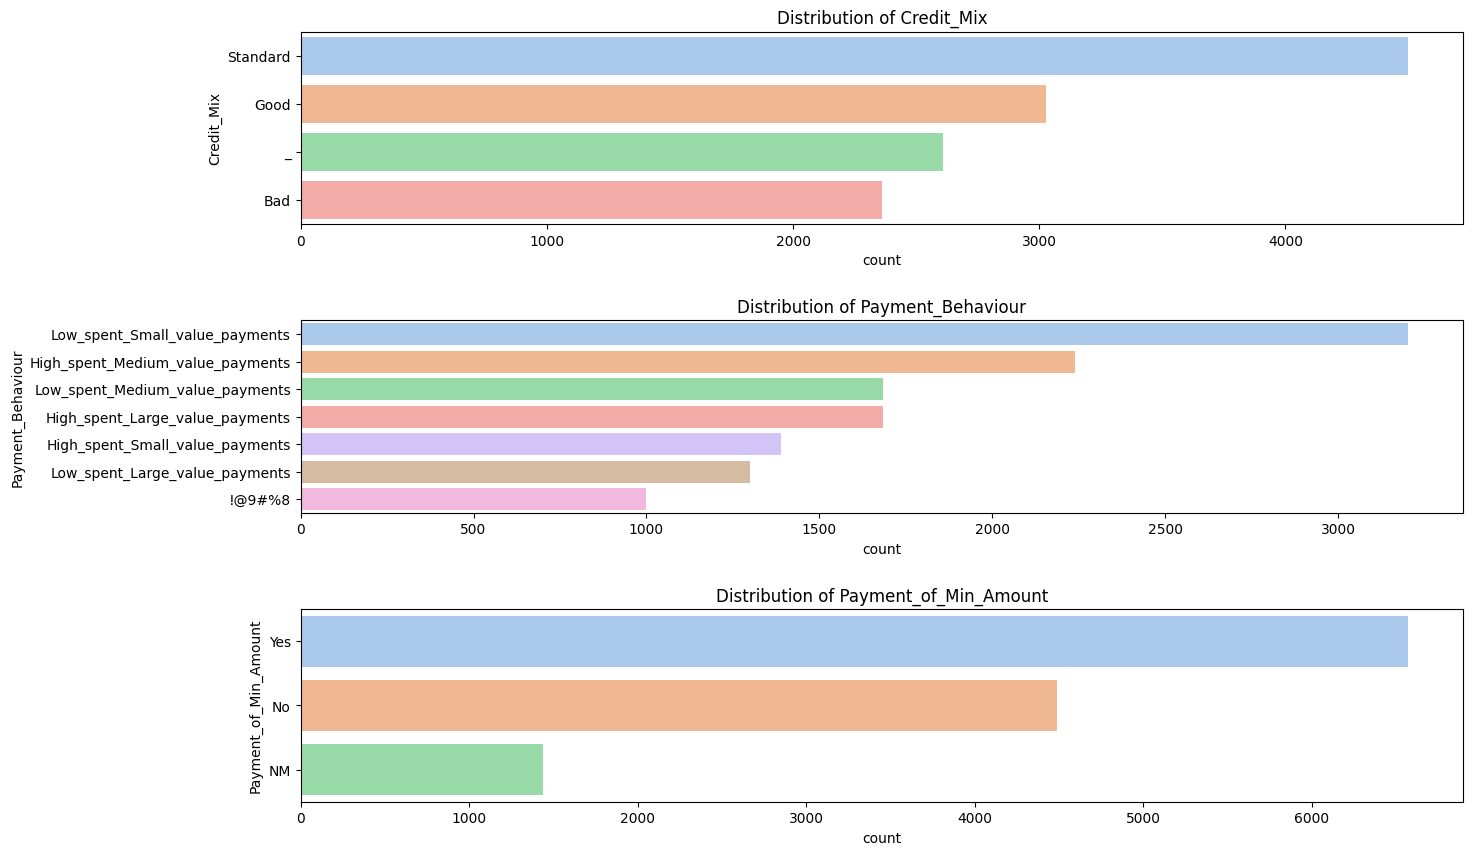

In [113]:
# EDA on credit mix
# Group by distinct values and count occurrences
cat_cols = ["Credit_Mix", "Payment_Behaviour", "Payment_of_Min_Amount"]
plt.figure(figsize=(15, 10))  

for col in cat_cols:
    # Get counts of each category, ordered by frequency
    y = df9.groupBy(col).agg(count("*").alias("count")).orderBy("count", ascending=False)
    y_pd = y.toPandas()
    
    # Create subplot
    plt.subplot(len(cat_cols), 1, cat_cols.index(col) + 1)
    
    # Properly specify x and y columns
    sns.barplot(hue=col, y=col, data=y_pd, palette="pastel", x="count", orient="h")
    plt.subplots_adjust(hspace=0.5)
    plt.title(f'Distribution of {col}')

In [28]:
test = fn.one_hot_encode_categorical(df9, "Credit_Mix")
test.show(truncate=False)

+-----------+-------------+---------------------+-----------------+---------------+-------------+-----------+------------------------------------------------------------------------------------------------------------------------------------------+-------------------+----------------------+--------------------+--------------------+----------+----------------+------------------------+---------------------+-------------------+-----------------------+--------------------------------+---------------+-------------+-------------------------+----------------------------------------------------------------------------------------------------------------------------------------+--------------------------+---------------------+-----------------------+---------------------------------+-----------------------+----------------------+-----------------------------+-------------------+-----------------------+------------+---------------+--------------+-------------------+
|Customer_ID|Annual_Income|Mo

In [16]:
df10 = df9.withColumn("Credit_Mix", F.when(F.col("Credit_Mix") == "_", "Invalid").otherwise(F.col("Credit_Mix"))) 
df10 = fn.one_hot_encode_categorical(df10, "Credit_Mix")
df10 = fn.one_hot_encode_categorical(df10, "Payment_of_Min_Amount")

df10.toPandas().head()

,Customer_ID,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,...,loan_type_credit_builder_loan,loan_type_auto_loan,loan_type_not_specified,credit_mix_good,credit_mix_bad,credit_mix_invalid,credit_mix_standard,payment_of_min_amount_nm,payment_of_min_amount_no,payment_of_min_amount_yes
0,CUS_0x1000,30625.94,2706.16,6,5,27.0,2,"Credit-Builder Loan, and Home Equity Loan",57,23,...,1,0,0,0,1,0,0,0,0,1
1,CUS_0x1009,52312.68,4250.39,6,5,17.0,4,"Not Specified, Home Equity Loan, Credit-Builde...",5,18,...,1,0,1,0,0,1,0,0,0,1
2,CUS_0x100b,113781.39,9549.78,1,4,1.0,0,No loan,14,8,...,0,0,0,1,0,0,0,0,1,0
3,CUS_0x1011,58918.47,5208.87,3,3,17.0,3,"Student Loan, Credit-Builder Loan, and Debt Co...",27,13,...,1,0,0,0,0,0,1,0,0,1
4,CUS_0x1013,98620.98,7962.42,3,3,6.0,3,"Student Loan, Debt Consolidation Loan, and Per...",12,9,...,0,0,0,1,0,0,0,0,1,0


In [18]:
# Extract spending level
df11 = df10.withColumn("Spending_Level", 
                      F.when(F.col("Payment_Behaviour").contains("High"), 1)
                      .when(F.col("Payment_Behaviour").contains("Low"), 0)
                      .otherwise(-1)) \
            .withColumn("Payment_Size",
                      F.when(F.col("Payment_Behaviour").contains("Small"), 1)
                      .when(F.col("Payment_Behaviour").contains("Medium"), 2)
                      .when(F.col("Payment_Behaviour").contains("Large"), 3)
                      .otherwise(0))
df11.toPandas().head()

,Customer_ID,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,...,loan_type_not_specified,credit_mix_good,credit_mix_bad,credit_mix_invalid,credit_mix_standard,payment_of_min_amount_nm,payment_of_min_amount_no,payment_of_min_amount_yes,Spending_Level,Payment_Size
0,CUS_0x1000,30625.94,2706.16,6,5,27.0,2,"Credit-Builder Loan, and Home Equity Loan",57,23,...,0,0,1,0,0,0,0,1,1,2
1,CUS_0x1009,52312.68,4250.39,6,5,17.0,4,"Not Specified, Home Equity Loan, Credit-Builde...",5,18,...,1,0,0,1,0,0,0,1,1,2
2,CUS_0x100b,113781.39,9549.78,1,4,1.0,0,No loan,14,8,...,0,1,0,0,0,0,1,0,1,1
3,CUS_0x1011,58918.47,5208.87,3,3,17.0,3,"Student Loan, Credit-Builder Loan, and Debt Co...",27,13,...,0,0,0,0,1,0,0,1,0,2
4,CUS_0x1013,98620.98,7962.42,3,3,6.0,3,"Student Loan, Debt Consolidation Loan, and Per...",12,9,...,0,1,0,0,0,0,1,0,1,2


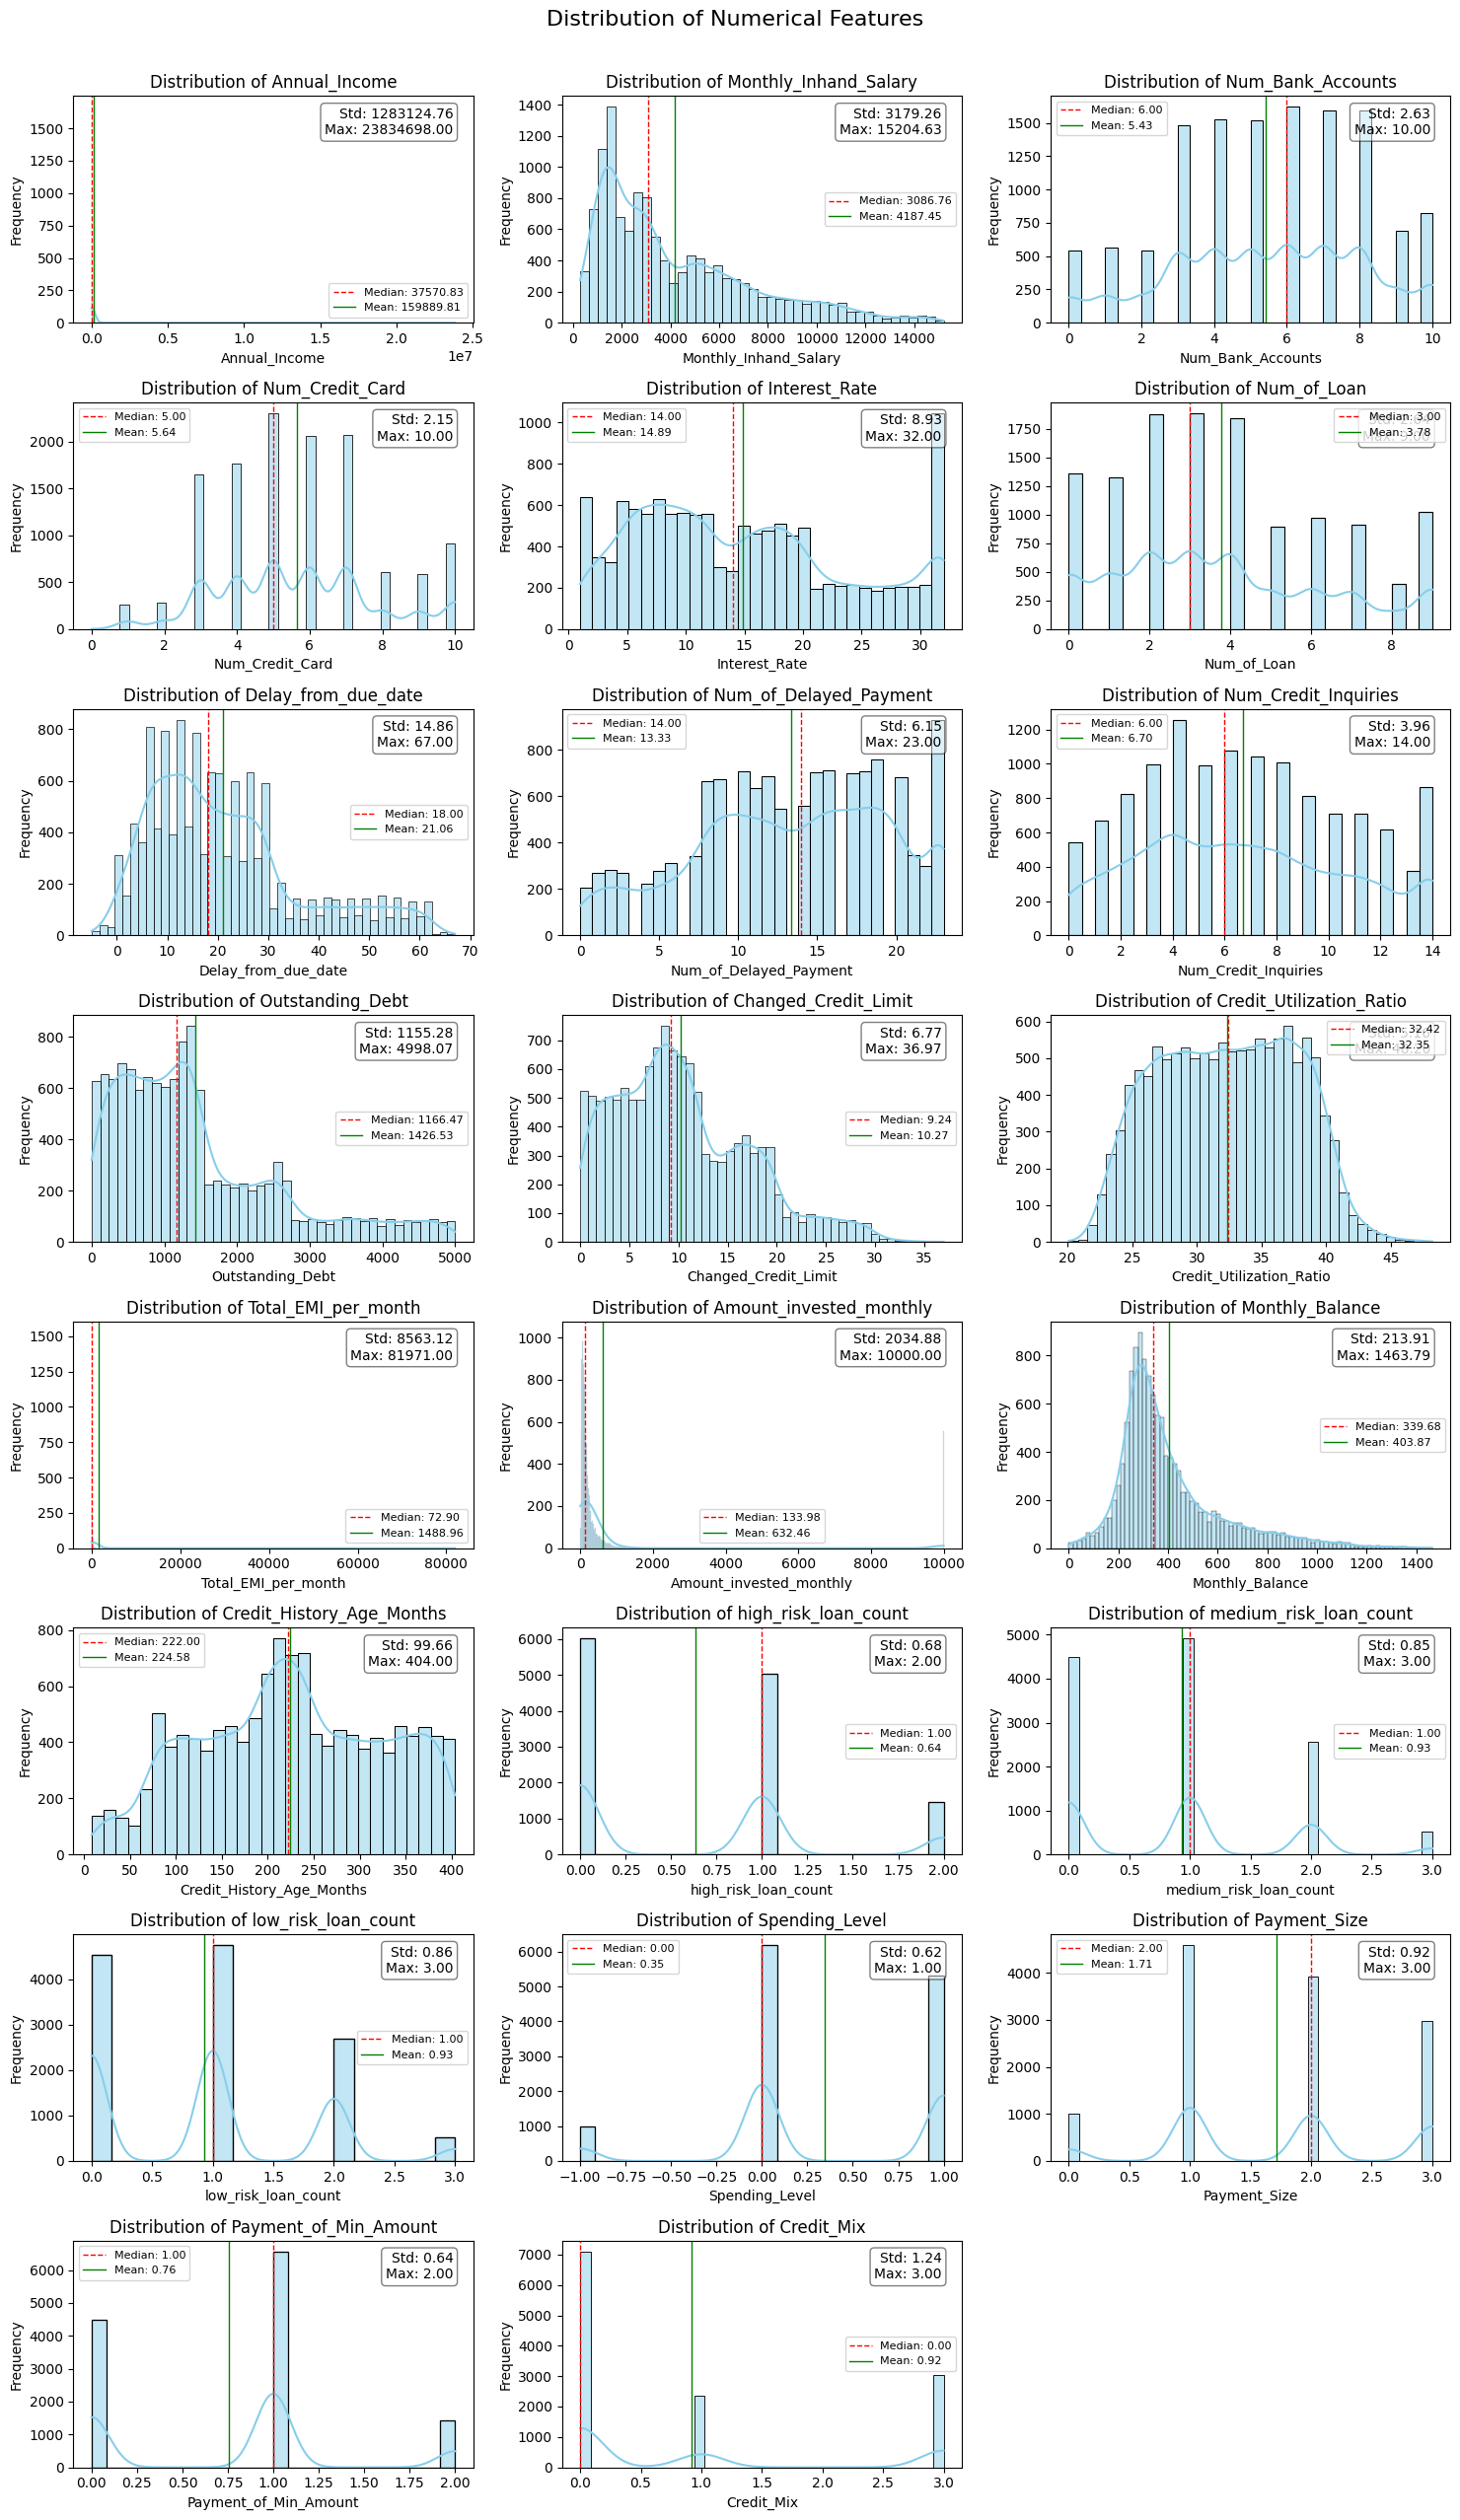

In [138]:
def plot_distributions(df, numeric_cols, n_cols=3, figsize=(20, 15)):
    """
    Create subplots of distributions for numerical columns in a PySpark DataFrame
    
    Parameters:
    - df: PySpark DataFrame
    - numeric_cols: List of numeric column names to plot
    - n_cols: Number of columns in the subplot grid
    - figsize: Figure size as (width, height) tuple
    """
    # Convert to pandas for plotting
    pandas_df = df.select(numeric_cols).toPandas()
    
    # Calculate number of rows needed
    n_rows = math.ceil(len(numeric_cols) / n_cols)
    
    # Create figure and axes
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten()  # Flatten to make indexing easier
    
    # Plot each column
    for i, col in enumerate(numeric_cols):
        # Get data and plot
        ax = axes[i]
        
        # Plot distribution
        sns.histplot(pandas_df[col], kde=True, ax=ax, color='skyblue')
        
        # Add vertical lines for statistics
        median = pandas_df[col].median()
        mean = pandas_df[col].mean()
        ax.axvline(median, color='red', linestyle='--', linewidth=1, label=f'Median: {median:.2f}')
        ax.axvline(mean, color='green', linestyle='-', linewidth=1, label=f'Mean: {mean:.2f}')
        
        # Add title and labels
        ax.set_title(f'Distribution of {col}', fontsize=12)
        ax.set_xlabel(col)
        ax.set_ylabel('Frequency')
        ax.legend(fontsize=8)
        
        # Add more stats as text
        stats_text = f"Std: {pandas_df[col].std():.2f}\nMax: {pandas_df[col].max():.2f}"
        ax.text(0.95, 0.95, stats_text, transform=ax.transAxes, 
                verticalalignment='top', horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    
    # Hide unused subplots
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)
    
    # Adjust layout and add title
    plt.tight_layout()
    plt.suptitle('Distribution of Numerical Features', fontsize=16, y=1.02)
    plt.savefig('numeric_distributions.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_cols = ['Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 
                'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 
                'Delay_from_due_date', 'Num_of_Delayed_Payment', 
                'Num_Credit_Inquiries', 'Outstanding_Debt', 
                'Changed_Credit_Limit','Credit_Utilization_Ratio', 'Total_EMI_per_month', 
                'Amount_invested_monthly', 'Monthly_Balance', 
                'Credit_History_Age_Months', 'high_risk_loan_count', 
                'medium_risk_loan_count', 'low_risk_loan_count',
                'Spending_Level', 'Payment_Size', 'Payment_of_Min_Amount', 'Credit_Mix']

plot_distributions(df11, plot_cols, n_cols=3, figsize=(15, 25))

In [24]:
df11.columns

['Customer_ID',
 'Annual_Income',
 'Monthly_Inhand_Salary',
 'Num_Bank_Accounts',
 'Num_Credit_Card',
 'Interest_Rate',
 'Num_of_Loan',
 'Type_of_Loan',
 'Delay_from_due_date',
 'Num_of_Delayed_Payment',
 'Changed_Credit_Limit',
 'Num_Credit_Inquiries',
 'Credit_Mix',
 'Outstanding_Debt',
 'Credit_Utilization_Ratio',
 'Payment_of_Min_Amount',
 'Total_EMI_per_month',
 'Amount_invested_monthly',
 'Payment_Behaviour',
 'Monthly_Balance',
 'snapshot_date',
 'Credit_History_Age_Months',
 'loan_types_array',
 'loan_type_no_loan',
 'loan_type_home_equity_loan',
 'loan_type_payday_loan',
 'loan_type_personal_loan',
 'loan_type_debt_consolidation_loan',
 'loan_type_mortgage_loan',
 'loan_type_student_loan',
 'loan_type_credit_builder_loan',
 'loan_type_auto_loan',
 'loan_type_not_specified',
 'Spending_Level',
 'Payment_Size']

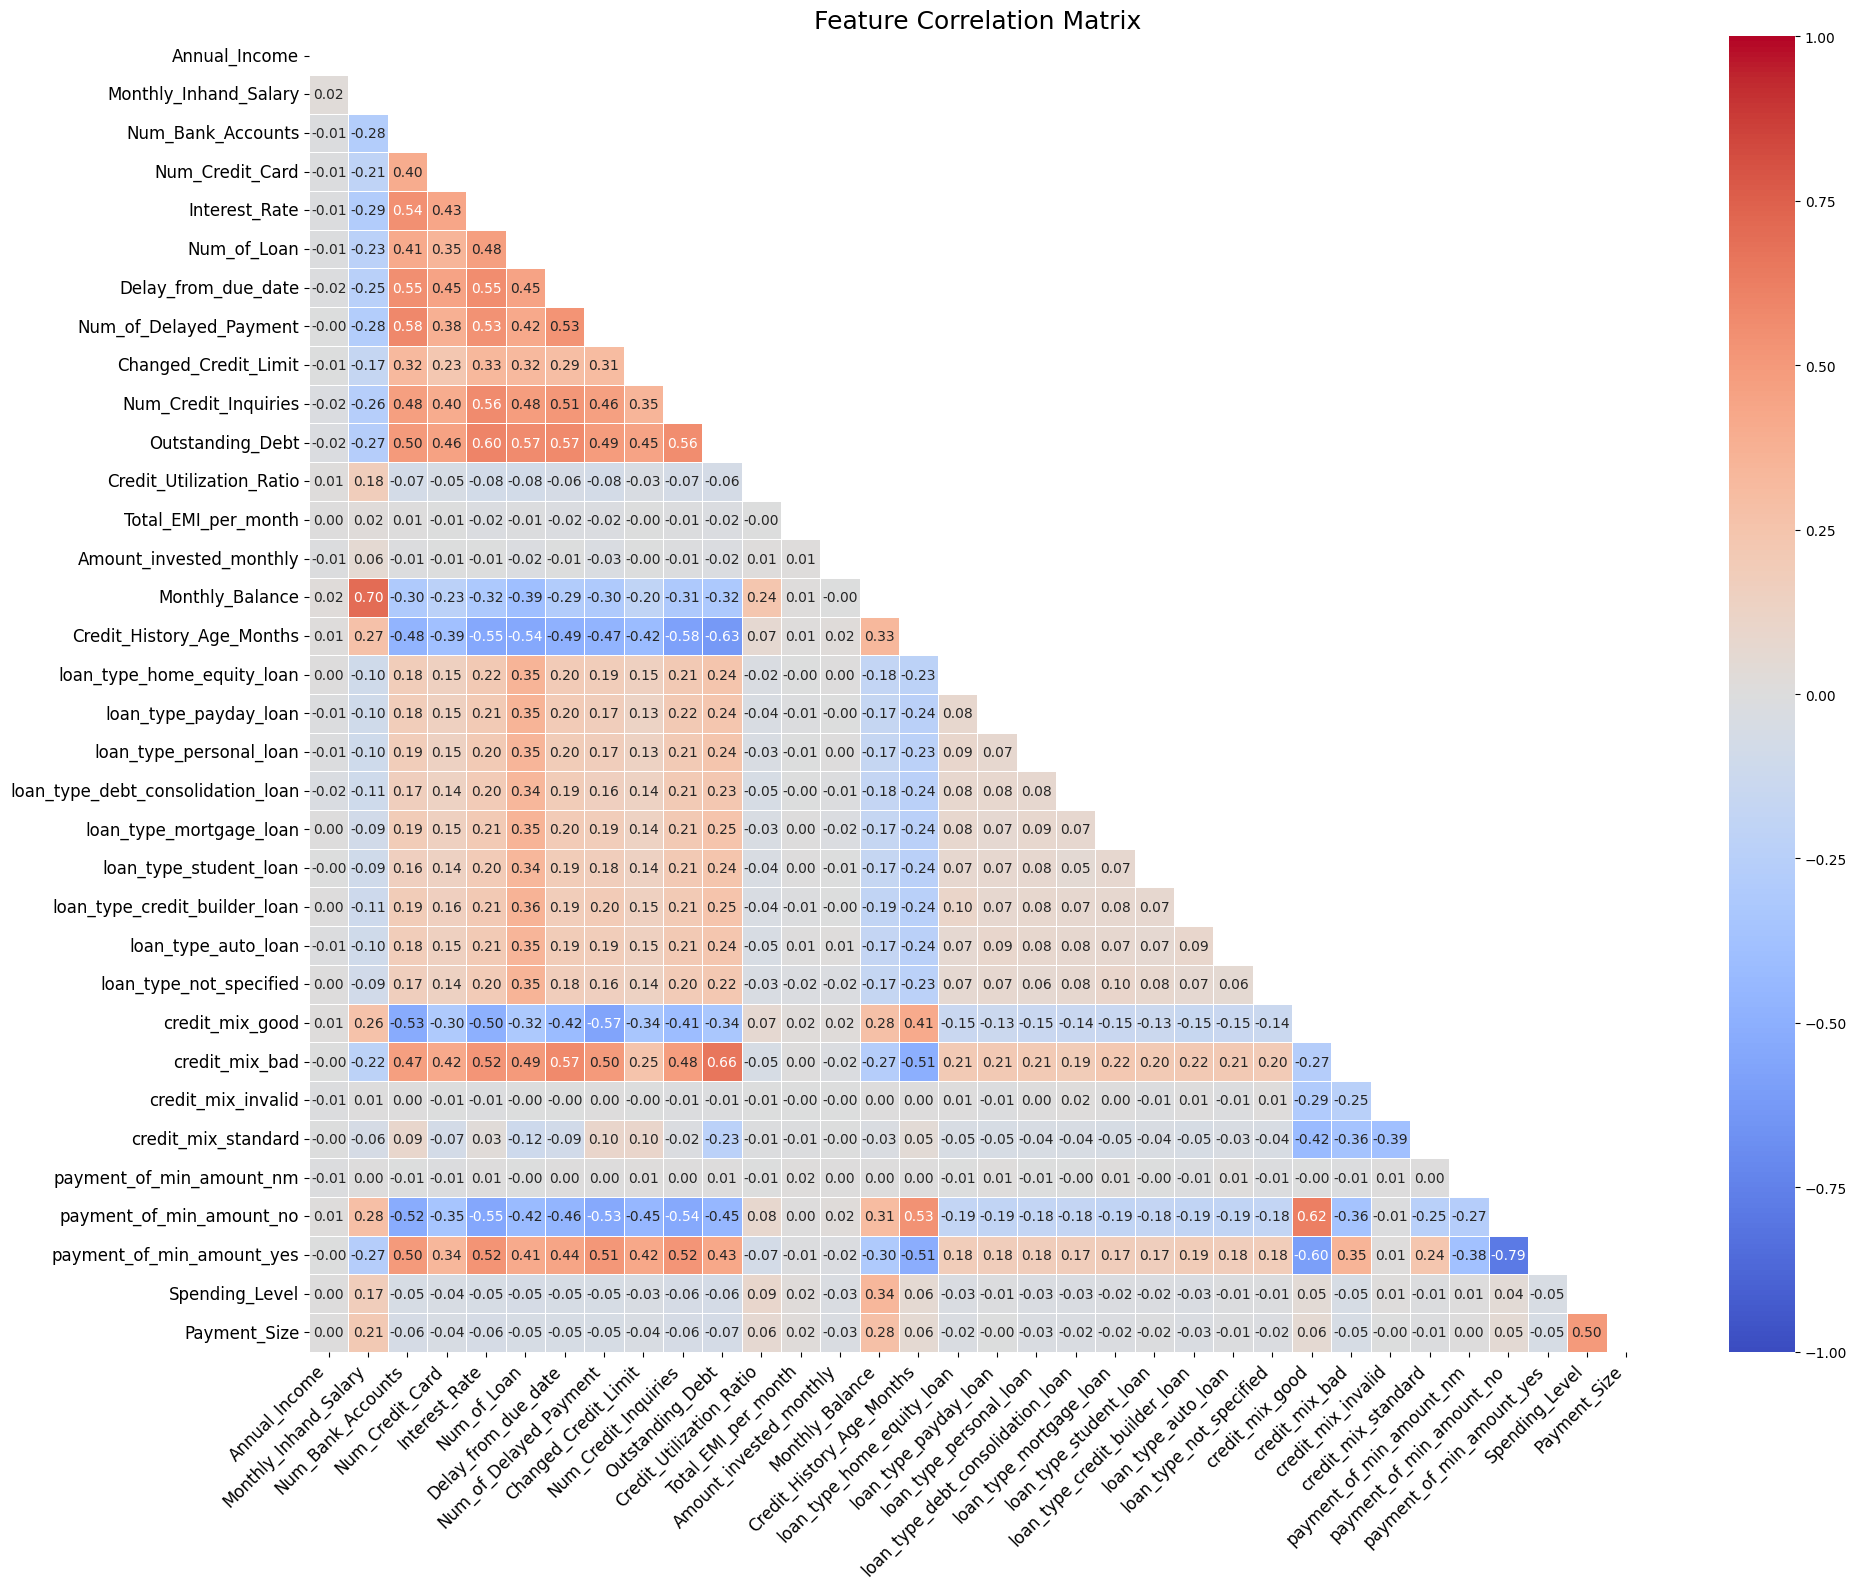

Highly correlated feature pairs (|r| > 0.7):
payment_of_min_amount_no and payment_of_min_amount_yes: -0.788
Monthly_Inhand_Salary and Monthly_Balance: 0.701


In [37]:
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.stat import Correlation

corr_cols = [col_name for col_name, dtype in df11.dtypes if dtype in ('int', 'double', 'float')]

# Select only numeric columns for correlation
df_numeric = df11.select(corr_cols)

# Assemble features into a vector column
assembler = VectorAssembler(inputCols=corr_cols, outputCol="features")
df_vector = assembler.transform(df_numeric).select("features")

# Compute correlation matrix
correlation = Correlation.corr(df_vector, "features", "pearson").collect()[0][0]
corr_matrix = correlation.toArray().tolist()

#Convert to pandas 
corr_df = pd.DataFrame(data=corr_matrix, columns=corr_cols, index=corr_cols)

plt.figure(figsize=(20, 16))
mask = np.triu(np.ones_like(corr_df, dtype=bool))  # Create a mask for the upper triangle
sns.heatmap(corr_df, mask=mask, annot=True, fmt=".2f", cmap="coolwarm", 
            linewidths=0.5, vmin=-1, vmax=1)
plt.title('Feature Correlation Matrix', fontsize=18)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Step 7: Identify highly correlated features (|r| > 0.7)
high_corr = []
for i in range(len(corr_cols)):
    for j in range(i+1, len(corr_cols)):
        if abs(corr_matrix[i][j]) > 0.7:
            high_corr.append((corr_cols[i], corr_cols[j], corr_matrix[i][j]))

# Print highly correlated pairs, sorted by absolute correlation
print("Highly correlated feature pairs (|r| > 0.7):")
for col1, col2, corr in sorted(high_corr, key=lambda x: abs(x[2]), reverse=True):
    print(f"{col1} and {col2}: {corr:.3f}")

In [19]:
new_financials_df = df11.drop("Monthly_Inhand_Salary", "Type_of_Loan", "Payment_Behaviour", "loan_types_array", "payment_of_min_amount", "payment_of_min_amount_no", "credit_mix")
new_financials_df.show()

+-----------+-------------+-----------------+---------------+-------------+-----------+-------------------+----------------------+--------------------+--------------------+----------------+------------------------+-------------------+-----------------------+---------------+-------------+-------------------------+--------------------------+---------------------+-----------------------+---------------------------------+-----------------------+----------------------+-----------------------------+-------------------+-----------------------+---------------+--------------+------------------+-------------------+------------------------+-------------------------+--------------+------------+
|Customer_ID|Annual_Income|Num_Bank_Accounts|Num_Credit_Card|Interest_Rate|Num_of_Loan|Delay_from_due_date|Num_of_Delayed_Payment|Changed_Credit_Limit|Num_Credit_Inquiries|Outstanding_Debt|Credit_Utilization_Ratio|Total_EMI_per_month|Amount_invested_monthly|Monthly_Balance|snapshot_date|Credit_History_Age_M

# EDA & Preprocessing for attributes dataset

In [20]:
attributes_df = spark.read.csv("data/features_attributes.csv", header=True, inferSchema=True)
attributes_df.toPandas()

,Customer_ID,Name,Age,SSN,Occupation,snapshot_date
0,CUS_0x1000,Alistair Barrf,18,913-74-1218,Lawyer,2023-05-01
1,CUS_0x1009,Arunah,26,063-67-6938,Mechanic,2025-01-01
2,CUS_0x100b,Shirboni,19,#F%$D@*&8,Media_Manager,2024-03-01
3,CUS_0x1011,Schneyerh,44,793-05-8223,Doctor,2023-11-01
4,CUS_0x1013,Cameront,44,930-49-9615,Mechanic,2023-12-01
...,...,...,...,...,...,...
12495,CUS_0xff3,Somervilled,55,#F%$D@*&8,Scientist,2024-06-01
12496,CUS_0xff4,Poornimaf,37,655-05-7666,Entrepreneur,2024-12-01
12497,CUS_0xff6,Shieldsb,19,541-92-8371,Doctor,2024-10-01
12498,CUS_0xffc,Brads,18,226-86-7294,Musician,2024-01-01


In [31]:
attributes_df.dtypes

[('Customer_ID', 'string'),
 ('Name', 'string'),
 ('Age', 'string'),
 ('SSN', 'string'),
 ('Occupation', 'string'),
 ('snapshot_date', 'date')]

In [49]:
distinct_values = attributes_df.select("Occupation").distinct()
distinct_values.show(truncate=False)

+-------------+
|Occupation   |
+-------------+
|Scientist    |
|Media_Manager|
|Musician     |
|Lawyer       |
|Teacher      |
|Developer    |
|Writer       |
|Architect    |
|Mechanic     |
|Entrepreneur |
|Journalist   |
|Doctor       |
|Engineer     |
|Accountant   |
|Manager      |
|_______      |
+-------------+



In [21]:
attributes_df = attributes_df.withColumn("Occupation", F.when(~F.col("Occupation").rlike('[a-zA-Z]'), "Others")
                             .otherwise(F.col("Occupation"))) \
                             .withColumn("has_SSN", F.when(~F.col("SSN").rlike("[0-9]{3}-[0-9]{2}-[0-9]{4}"), F.lit(0))
                             .otherwise(1)) 
attributes_df.toPandas().head()

,Customer_ID,Name,Age,SSN,Occupation,snapshot_date,has_SSN
0,CUS_0x1000,Alistair Barrf,18,913-74-1218,Lawyer,2023-05-01,1
1,CUS_0x1009,Arunah,26,063-67-6938,Mechanic,2025-01-01,1
2,CUS_0x100b,Shirboni,19,#F%$D@*&8,Media_Manager,2024-03-01,0
3,CUS_0x1011,Schneyerh,44,793-05-8223,Doctor,2023-11-01,1
4,CUS_0x1013,Cameront,44,930-49-9615,Mechanic,2023-12-01,1


In [22]:
attributes_df = fn.one_hot_encode_categorical(attributes_df, "Occupation")

# View the result
attributes_df.show()

+-----------+-----------------+---+-----------+-------------+-------------+-------+--------------------+------------------------+-------------------+-----------------+------------------+--------------------+-----------------+--------------------+-------------------+-----------------------+-----------------+---------------------+-----------------+-------------------+---------------------+------------------+
|Customer_ID|             Name|Age|        SSN|   Occupation|snapshot_date|has_SSN|occupation_scientist|occupation_media_manager|occupation_musician|occupation_lawyer|occupation_teacher|occupation_developer|occupation_writer|occupation_architect|occupation_mechanic|occupation_entrepreneur|occupation_others|occupation_journalist|occupation_doctor|occupation_engineer|occupation_accountant|occupation_manager|
+-----------+-----------------+---+-----------+-------------+-------------+-------+--------------------+------------------------+-------------------+-----------------+-------------

In [23]:
attributes_df = attributes_df.withColumn("Age", regexp_replace(F.col("Age"), "[^0-9]", ""))
attributes_df = attributes_df.withColumn("Age", F.col("Age").cast("int"))
check_df = attributes_df.toPandas()
check_df['Age'].info()    

<class 'pandas.core.series.Series'>
RangeIndex: 12500 entries, 0 to 12499
Series name: Age
Non-Null Count  Dtype
--------------  -----
12500 non-null  int32
dtypes: int32(1)
memory usage: 49.0 KB


In [54]:
check_df['Age'].describe() 

count   11863.00
mean      104.41
std       659.48
min      -500.00
25%        25.00
50%        33.00
75%        42.00
max      8678.00
Name: Age, dtype: float64

In [24]:
median_age = attributes_df.approxQuantile("Age", [0.5], 0.01)[0]
attributes_df = attributes_df.withColumn("Age", F.when((F.col("Age") > 100) | F.col("Age").isNull(), median_age)  
                                                    .otherwise(F.col("Age")))
attributes_df.show()

+-----------+-----------------+----+-----------+-------------+-------------+-------+--------------------+------------------------+-------------------+-----------------+------------------+--------------------+-----------------+--------------------+-------------------+-----------------------+-----------------+---------------------+-----------------+-------------------+---------------------+------------------+
|Customer_ID|             Name| Age|        SSN|   Occupation|snapshot_date|has_SSN|occupation_scientist|occupation_media_manager|occupation_musician|occupation_lawyer|occupation_teacher|occupation_developer|occupation_writer|occupation_architect|occupation_mechanic|occupation_entrepreneur|occupation_others|occupation_journalist|occupation_doctor|occupation_engineer|occupation_accountant|occupation_manager|
+-----------+-----------------+----+-----------+-------------+-------------+-------+--------------------+------------------------+-------------------+-----------------+----------

In [44]:
attributes_df.toPandas().describe()

,Age,has_SSN,occupation_scientist,occupation_media_manager,occupation_musician,occupation_lawyer,occupation_teacher,occupation_developer,occupation_writer,occupation_architect,occupation_mechanic,occupation_entrepreneur,occupation_others,occupation_journalist,occupation_doctor,occupation_engineer,occupation_accountant,occupation_manager
count,12500.000000,12500.000000,12500.000000,12500.00000,12500.000000,12500.000000,12500.00000,12500.00000,12500.000000,12500.000000,12500.00000,12500.00000,12500.00000,12500.00000,12500.000000,12500.000000,12500.000000,12500.000000
mean,33.628800,0.943760,0.063120,0.06240,0.059280,0.066240,0.06256,0.06240,0.058240,0.063600,0.06240,0.06208,0.07040,0.06088,0.060800,0.063440,0.063280,0.058880
std,10.631187,0.230394,0.243188,0.24189,0.236157,0.248711,0.24218,0.24189,0.234206,0.244049,0.24189,0.24131,0.25583,0.23912,0.238973,0.243762,0.243476,0.235409
min,14.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,25.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,34.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000
75%,42.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000
max,56.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.00000,1.00000,1.000000,1.000000,1.00000,1.00000,1.00000,1.00000,1.000000,1.000000,1.000000,1.000000


In [25]:
new_attributes_df = attributes_df.drop("Occupation", "SSN", "Name")

In [26]:
features_df = new_financials_df.join(new_attributes_df, on=["Customer_ID","snapshot_date"], how="inner")
features_df.toPandas().shape

(12495, 52)

In [28]:
features_df.show(truncate=False)

+-----------+-------------+-------------+-----------------+---------------+-------------+-----------+-------------------+----------------------+--------------------+--------------------+----------------+------------------------+-------------------+-----------------------+---------------+-------------------------+--------------------------+---------------------+-----------------------+---------------------------------+-----------------------+----------------------+-----------------------------+-------------------+-----------------------+---------------+--------------+------------------+-------------------+------------------------+-------------------------+--------------+------------+----+-------+--------------------+------------------------+-------------------+-----------------+------------------+--------------------+-----------------+--------------------+-------------------+-----------------------+-----------------+---------------------+-----------------+-------------------+-----------

In [27]:
clickstream_data = "data/feature_clickstream.csv"

# Load CSV into DataFrame - connect to feature store
cs_df = spark.read.csv(clickstream_data, header=True, inferSchema=True)
print("row_count:",cs_df.count())

cs_df = features_df.join(cs_df, on="Customer_ID", how="inner")
fe_count = [num for num in range(1,21)]

column_type_map = {
    f'fe_{num}': FloatType() for num in fe_count
}

for column, new_type in column_type_map.items():
    cs_df = cs_df.withColumn(column, col(column).cast(new_type))

cs_df.toPandas().shape

row_count: 215376


(215304, 73)

In [29]:
checkdf = features_df.join(cs_df, on="Customer_ID", how="inner")
checkdf.toPandas()

,Customer_ID,snapshot_date,Annual_Income,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,...,fe_12,fe_13,fe_14,fe_15,fe_16,fe_17,fe_18,fe_19,fe_20,snapshot_date
0,CUS_0x6ba9,2023-05-01,20272.23,4,3,12.0,1,-1,5,4.83,...,-53.0,50.0,16.0,45.0,10.0,85.0,274.0,-26.0,397.0,2023-01-01
1,CUS_0x74c7,2023-05-01,87853.56,4,1,4.0,2,2,2,9.99,...,100.0,156.0,80.0,97.0,-88.0,104.0,132.0,-59.0,94.0,2023-01-01
2,CUS_0xc65,2023-05-01,148699.32,3,4,5.0,3,16,8,9.20,...,129.0,174.0,71.0,178.0,121.0,141.0,202.0,140.0,76.0,2023-01-01
3,CUS_0x5a8b,2024-02-01,41771.88,3,6,32.0,2,16,12,0.94,...,113.0,-15.0,146.0,-51.0,32.0,211.0,207.0,77.0,112.0,2023-01-01
4,CUS_0x78d3,2024-02-01,17773.78,3,1,2.0,2,5,2,4.57,...,113.0,104.0,191.0,-8.0,235.0,56.0,158.0,41.0,9.0,2023-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215299,CUS_0x915,2023-08-01,19562.47,3,3,9.0,3,8,9,19.35,...,124.0,184.0,168.0,18.0,166.0,184.0,109.0,103.0,141.0,2024-12-01
215300,CUS_0xe60,2023-07-01,17340.78,6,10,10.0,2,10,10,18.07,...,147.0,304.0,155.0,31.0,240.0,97.0,108.0,232.0,293.0,2024-12-01
215301,CUS_0x219c,2023-09-01,30812.96,1,7,3.0,1,10,5,8.21,...,119.0,58.0,54.0,119.0,280.0,85.0,104.0,76.0,73.0,2024-12-01
215302,CUS_0x8b7c,2023-09-01,73826.31,3,7,15.0,3,14,13,11.46,...,40.0,-24.0,325.0,-78.0,159.0,222.0,277.0,55.0,-25.0,2024-12-01
